In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np
import eli5
from eli5.sklearn import PermutationImportance

warnings.filterwarnings('ignore')


font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 8}

plt.rc('font', **font)  # pass in the font dict as kwargs


df = pd.read_csv("/kaggle/input/cancer-data/Cancer_Data.csv")
#df.info()
#df.head()
df.dtypes


id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [2]:
mapDiag = {'B': 0, 'M': 1}
df['diagnosis'] = df['diagnosis'].map(mapDiag)

In [3]:
features = list(df.columns[2:32])
featuresdf = df[features]
target = df['diagnosis']

In [4]:
from sklearn.feature_selection import mutual_info_regression
discrete_features = featuresdf.dtypes == int
mi_scores = mutual_info_regression(featuresdf, target, discrete_features= discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=featuresdf.columns)
mi_scores = mi_scores.sort_values(ascending=False)

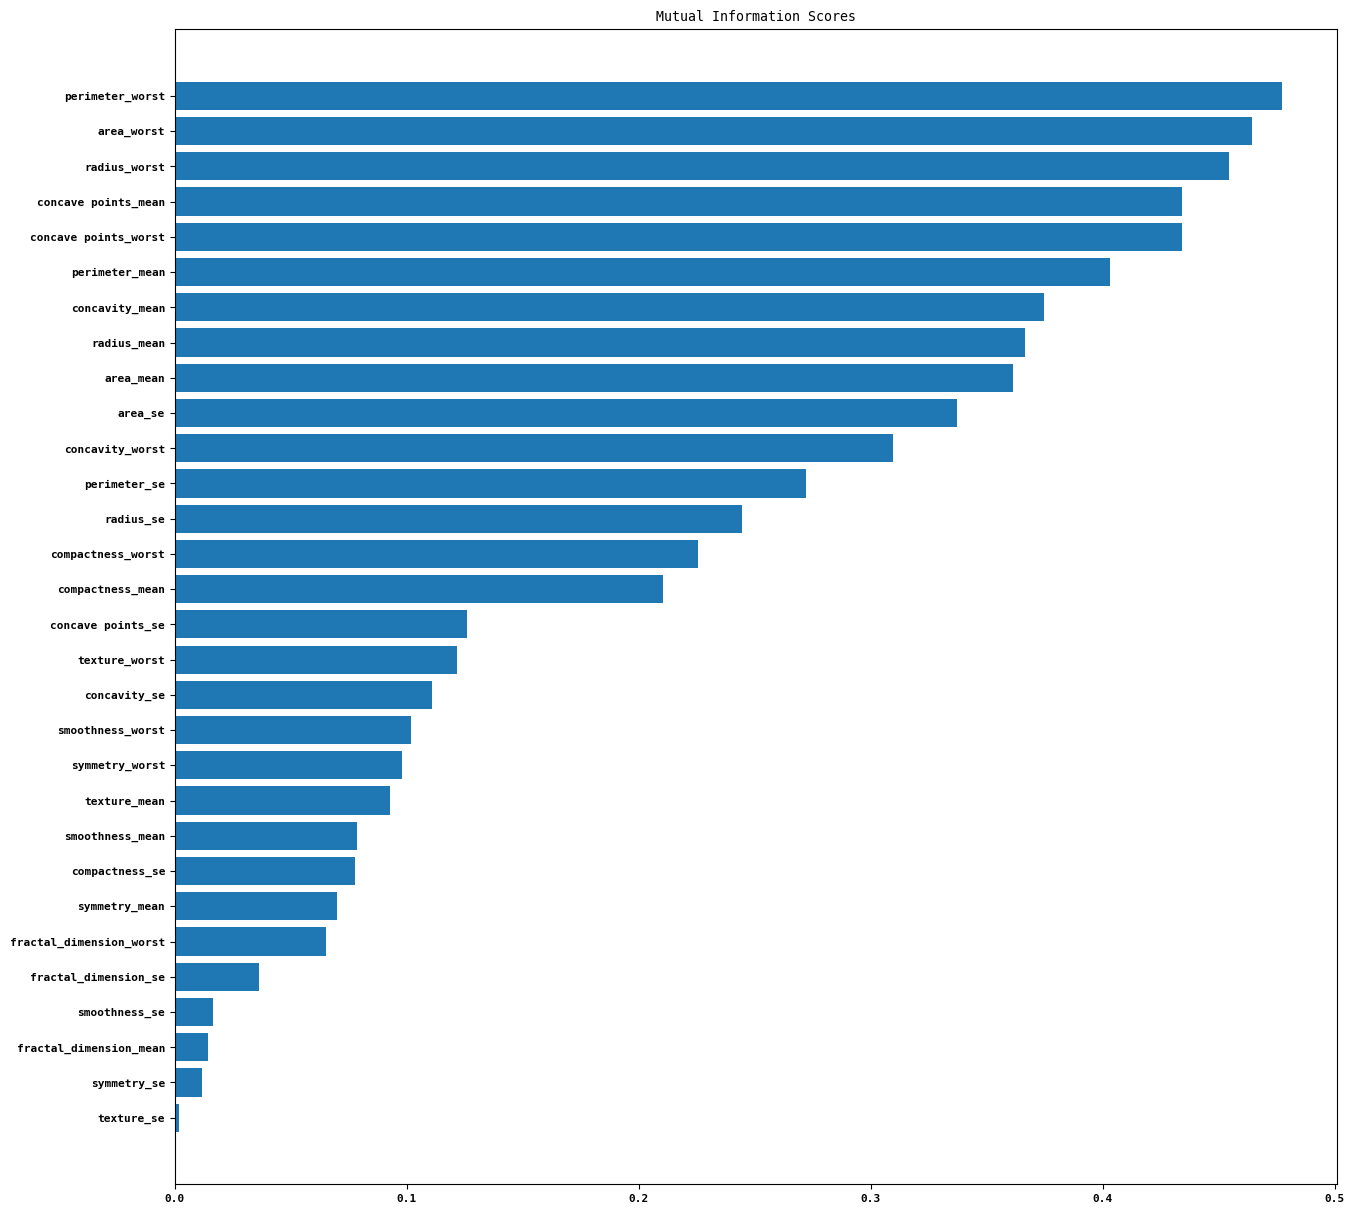

In [5]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(15, 15))
plot_mi_scores(mi_scores)

<AxesSubplot:>

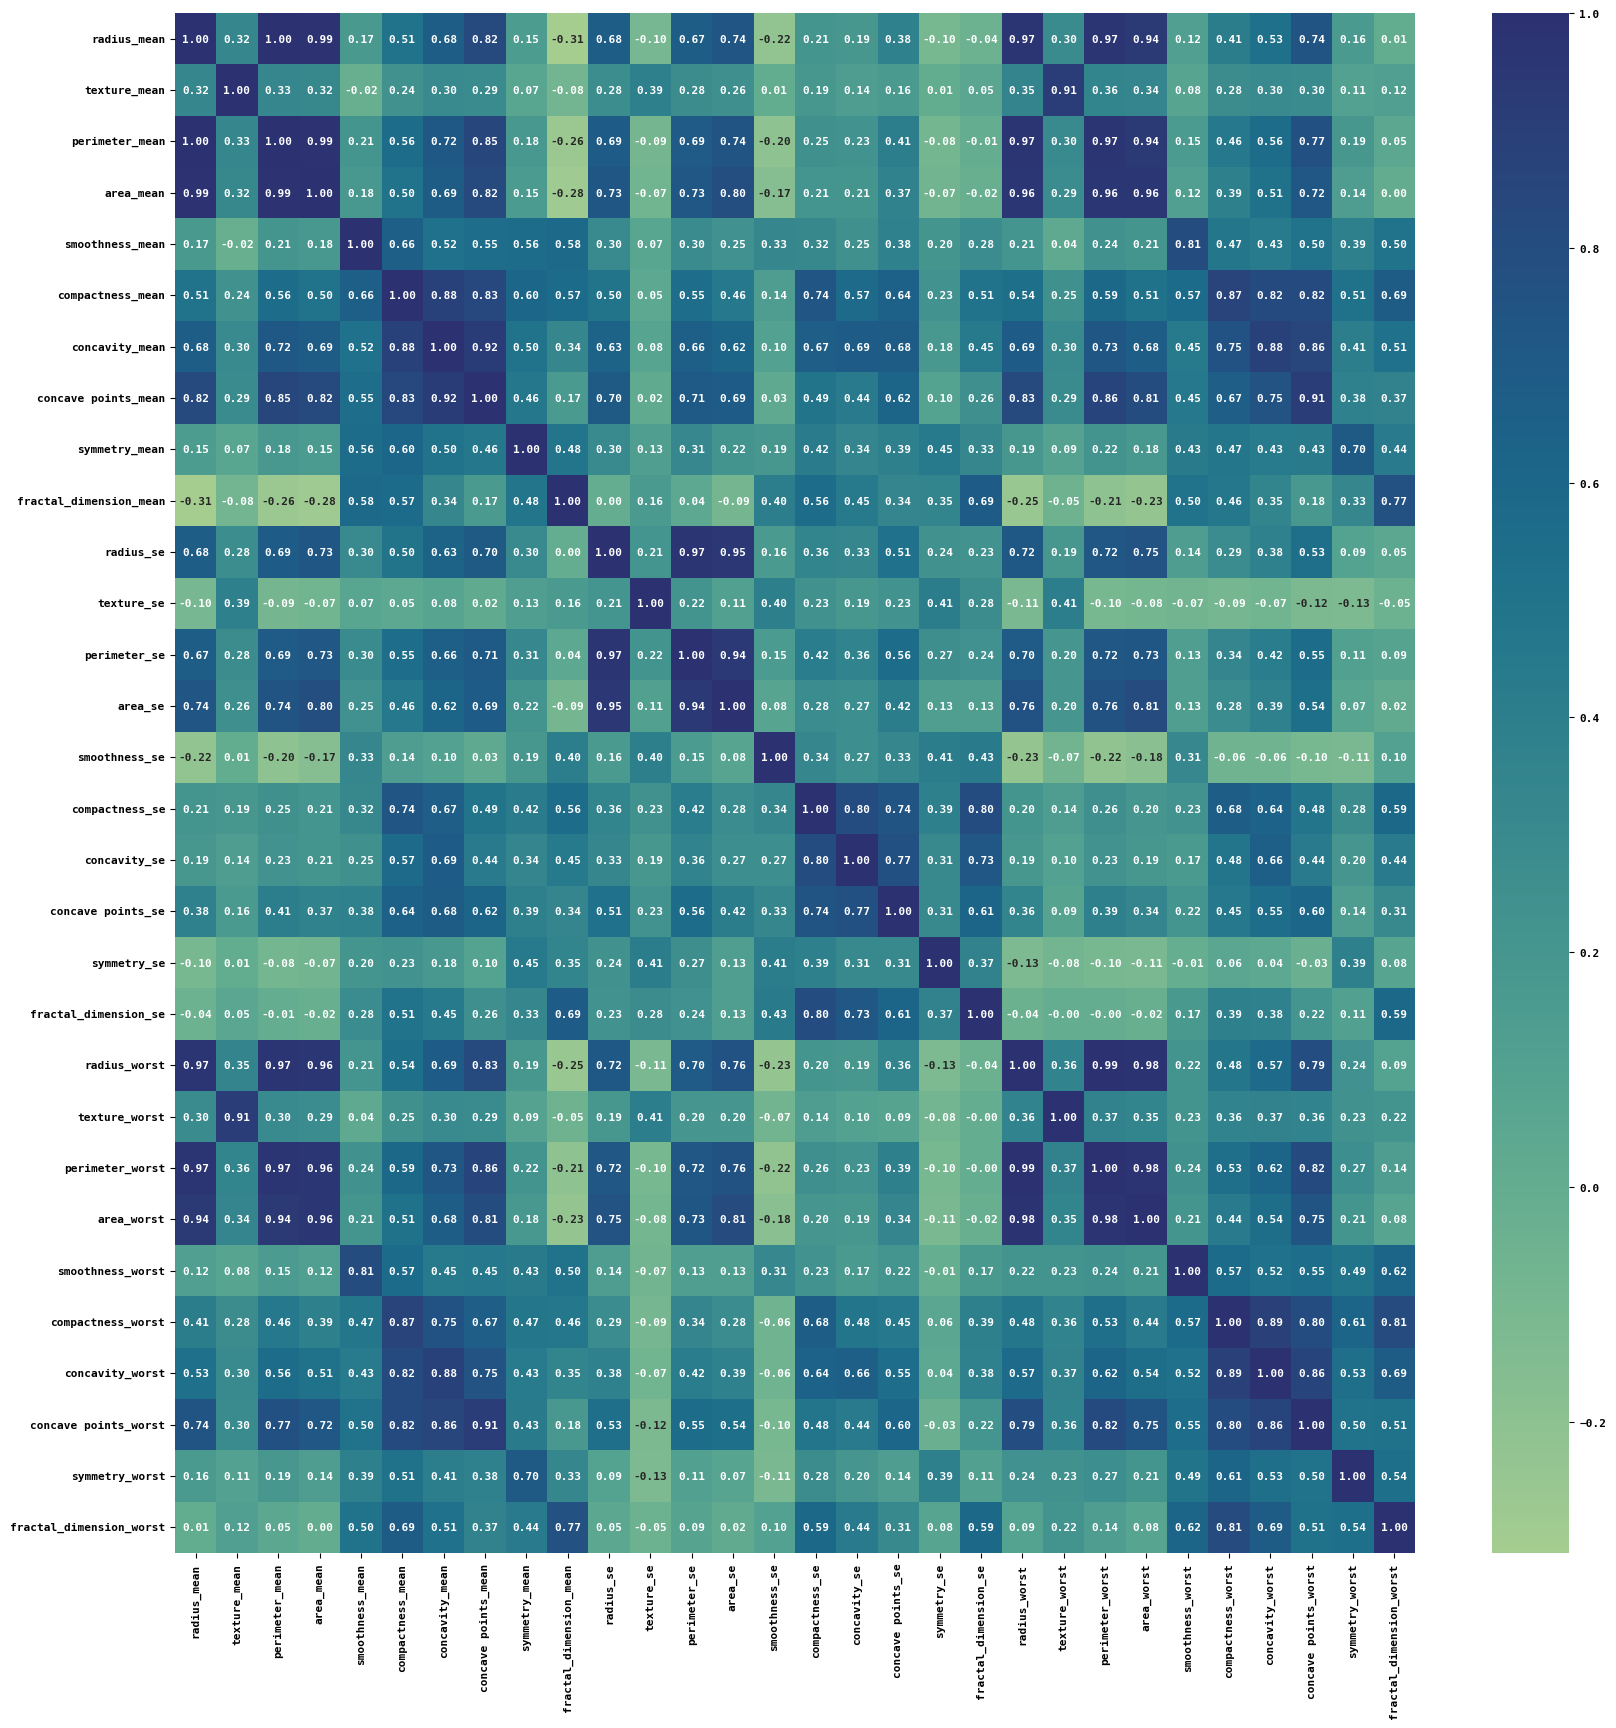

In [6]:
plt.figure(figsize=(20,20))
sns.heatmap(featuresdf.corr(), annot=True, fmt=".2f", cmap="crest")

In [7]:
from sklearn.model_selection import train_test_split

x = list(df.columns[2:32])
x = df[x]
y = target

xTrain, xTest,yTrain,yTest = train_test_split(x,y, test_size=.3, random_state=0)

In [8]:
from sklearn.metrics import accuracy_score
import xgboost as xgb

XGmodel = xgb.XGBClassifier(learning_rate = .5, n_estimators = 100, max_depth = 5, objective="binary:logistic").fit(xTrain,yTrain, eval_metric='logloss')
xgpred = XGmodel.predict(xTest)
xg = accuracy_score(yTest, xgpred)
print(f"The accuracy score of the XGBOOST classifier is {round(xg*100,4)}%")

The accuracy score of the XGBOOST classifier is 97.076%


Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

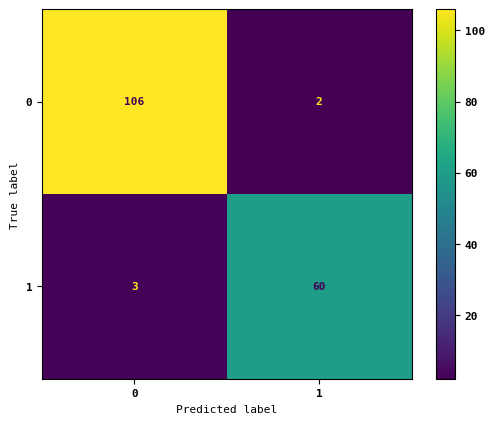

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(XGmodel, xTest, yTest)
df.columns[2:32]

In [10]:
from sklearn.linear_model import LogisticRegression

LRmodel = LogisticRegression(solver='liblinear', random_state=0, multi_class='ovr').fit(xTrain, yTrain)
logregpreds = LRmodel.predict(xTest)
score =accuracy_score(yTest, logregpreds)
print(f'Score is a {score}')

Score is a 0.9649122807017544


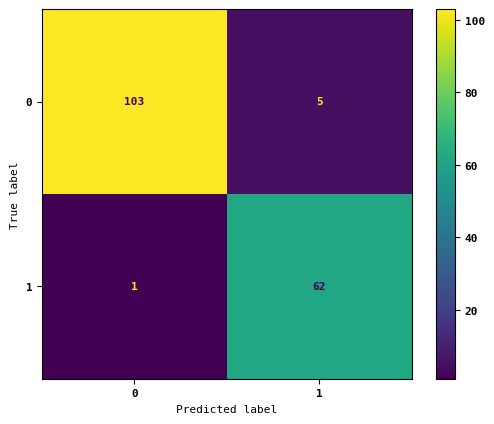

In [11]:
ConfusionMatrixDisplay.from_estimator(LRmodel, xTest, yTest)

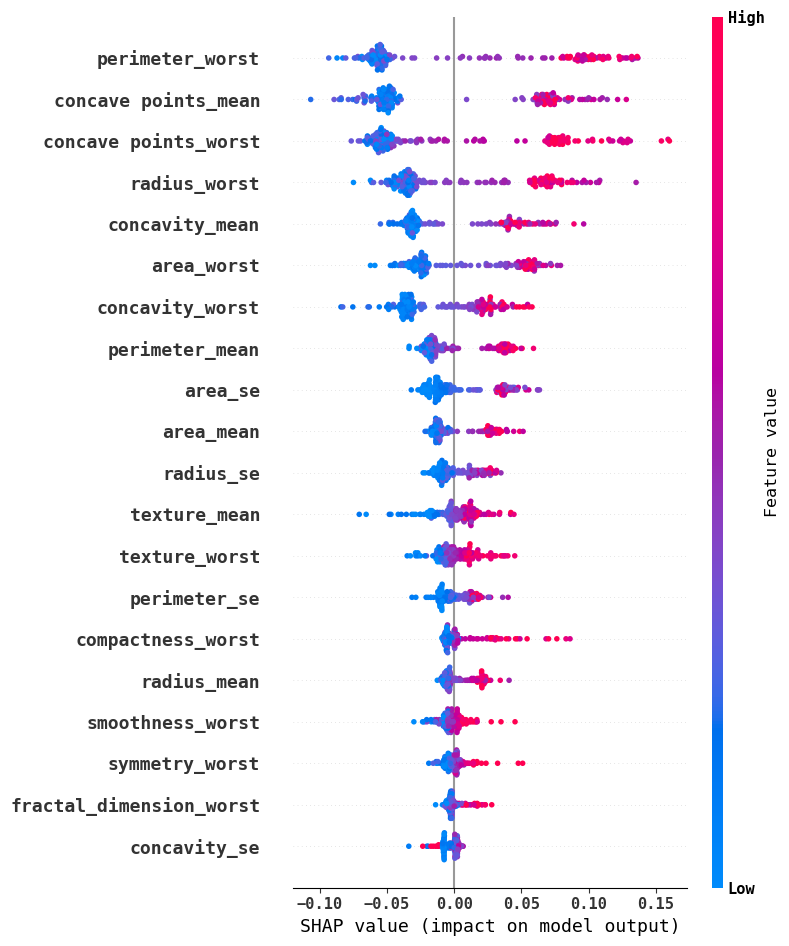

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0).fit(xTrain, yTrain)

import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf_model)

shap_values = explainer.shap_values(xTest)
shap.summary_plot(shap_values[1], xTest)